<a href="https://colab.research.google.com/github/vadim-privalov/Neiroset_Novosibirsk/blob/main/%D0%90%D0%B2%D1%82%D0%BE%D0%BC%D0%B0%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B5_%D1%80%D0%B0%D1%81%D0%BF%D0%BE%D0%B7%D0%BD%D0%B0%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%B0%D0%B2%D1%82%D0%BE%D0%BC%D0%BE%D0%B1%D0%B8%D0%BB%D1%8C%D0%BD%D1%8B%D1%85_%D0%BD%D0%BE%D0%BC%D0%B5%D1%80%D0%BE%D0%B2_%D0%92%D1%8B%D1%80%D0%B5%D0%B7%D0%B0%D0%BD%D0%B8%D0%B5_%D1%81%D0%B8%D0%BC%D0%B2%D0%BE%D0%BB%D0%BE%D0%B2_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="text-align: center;"><b>Автоматическое распознавание автомобильных номеров. Вырезание символов. </b></h1>

Это третий урок из цикла автоматического распознавания автомобильных номеров ANPR (Automatic number-plate recognition). В этом уроке мы научимся вырезать символы в области с номерным знаком.

Скачиваем файлы, необходимые для урока, и устанавливаем корневую папку проекта.

In [1]:
!wget http://dataudt.ru/datasets/cv/Lesson_39.ANPR.Scissoring_characters.zip
!unzip -qq Lesson_39.ANPR.Scissoring_characters.zip
%cd /content/Lesson_39.ANPR.Scissoring_characters/

--2022-02-07 10:48:13--  http://dataudt.ru/datasets/cv/Lesson_39.ANPR.Scissoring_characters.zip
Resolving dataudt.ru (dataudt.ru)... 37.228.117.130
Connecting to dataudt.ru (dataudt.ru)|37.228.117.130|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8828 (8.6K) [application/zip]
Saving to: ‘Lesson_39.ANPR.Scissoring_characters.zip’

Lesson_39.ANPR.Scis 100%[===================>]   8.62K  --.-KB/s    in 0s      

2022-02-07 10:48:14 (91.5 MB/s) - ‘Lesson_39.ANPR.Scissoring_characters.zip’ saved [8828/8828]

/content/Lesson_39.ANPR.Scissoring_characters


Скачиваем тестовый датасет для проверки работы алгоритма.

In [2]:
!wget http://dataudt.ru/datasets/cv/license_plate_test_dataset.zip
!unzip -qq license_plate_test_dataset.zip

--2022-02-07 10:48:44--  http://dataudt.ru/datasets/cv/license_plate_test_dataset.zip
Resolving dataudt.ru (dataudt.ru)... 37.228.117.130
Connecting to dataudt.ru (dataudt.ru)|37.228.117.130|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42576480 (41M) [application/zip]
Saving to: ‘license_plate_test_dataset.zip’

license_plate_test_ 100%[===================>]  40.60M  15.6MB/s    in 2.6s    

2022-02-07 10:48:47 (15.6 MB/s) - ‘license_plate_test_dataset.zip’ saved [42576480/42576480]



Импортируем необходимые модули.

In [3]:
# Основные модули.
from collections import namedtuple
from skimage.filters import threshold_local
from skimage import segmentation
from skimage import measure
from imutils import perspective

import numpy as np
import cv2
import imutils
from imutils.paths import list_images

# Функция для отображения изображений opencv в colab.
from google.colab.patches import cv2_imshow

Дополним ранее созданный класс детектора номерных знаков.

In [4]:
# define the named tupled to store the license plate
# определяем именованный кортеж для хранения номерного знака
LicensePlate = namedtuple("LicensePlateRegion", ["success", "plate", "thresh", "candidates"])

class LicensePlateDetector:
    def __init__(self, image, minPlateW=60, minPlateH=20, numChars=9, minCharW=40):
        # store the image to detect license plates in, the minimum width and height of the
        # license plate region, the number of characters to be detected in the license plate,
        # and the minimum width of the extracted characters
        # сохраним изображение для обнаружения номерных знаков,
        # минимальную ширину и высоту области номерного знака,
        # количество символов, которые должны быть 
        # обнаружены в номерном знаке, и 
        # минимальную ширину извлеченных символов
        self.image = image
        self.minPlateW = minPlateW
        self.minPlateH = minPlateH
        self.numChars = numChars
        self.minCharW = minCharW

    def detect(self):
        # detect license plate regions in the image
        # обнаруживаем регионы номерных знаков на изображении
        lpRegions = self.detectPlates()

        # loop over the license plate regions
        # перебираем регионы номерного знака
        for lpRegion in lpRegions:
            # detect character candidates in the current license plate region
            # обнаруживаем кандидатов в символы 
            # в текущем регионе номерного знака
            lp = self.detectCharacterCandidates(lpRegion)

            # only continue if characters were successfully detected
            # продолжим, только если символы 
            # были успешно обнаружены
            if lp.success:
                # scissor the candidates into characters
                # вырежем символы кандидаты 
                chars = self.scissor(lp)

                # yield a tuple of the license plate region and the characters
                # выведем кортеж региона номерного знака и символов
                yield (lpRegion, chars)

    def detectPlates(self):
        # initialize the rectangular and square kernels to be applied to the image,
        # then initialize the list of license plate regions
        # инициализируем прямоугольные и квадратные ядра, 
        # которые будут применены к изображению, 
        # затем инициализируем список регионов номерных знаков
        rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (13, 5)) # номерной знак
        squareKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3)) # закрытие пробелов в изображении с помощью операции закрытия
        regions = []

        # convert the image to grayscale, and apply the blackhat operation
        # преобразуем изображение в оттенки серого 
        # и применим операцию черной шляпы
        gray = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
        blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, rectKernel)

        # find regions in the image that are light
        # найдём светлые участки на изображении
        light = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, squareKernel)
        light = cv2.threshold(light, 50, 255, cv2.THRESH_BINARY)[1]

        # compute the Scharr gradient representation of the blackhat image in the x-direction,
        # and scale the resulting image into the range [0, 255]
        # вычислим представление градиента Щарра 
        # для изображения черной шляпы в направлении x 
        # и масштабируем получившееся изображение в диапазоне [0, 255]
        gradX = cv2.Sobel(blackhat,
            ddepth=cv2.cv.CV_32F if imutils.is_cv2() else cv2.CV_32F,
            dx=1, dy=0, ksize=-1)
        gradX = np.absolute(gradX)
        (minVal, maxVal) = (np.min(gradX), np.max(gradX))
        gradX = (255 * ((gradX - minVal) / (maxVal - minVal))).astype("uint8")

        # blur the gradient representation, apply a closing operating, and threshold the
        # image using Otsu's method
        # размываем представление градиента, 
        # применяем закрывающую операцию и 
        # порог изображения с помощью метода Оцу
        gradX = cv2.GaussianBlur(gradX, (5, 5), 0)
        gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKernel)
        thresh = cv2.threshold(gradX, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

        # perform a series of erosions and dilations on the image
        # выполним серию эрозий и расширений на изображении
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # take the bitwise 'and' between the 'light' regions of the image, then perform
        # another series of erosions and dilations
        # берем побитовое 'и' между 'светлыми' участками изображения, 
        # затем выполняем еще одну серию эрозий и расширений
        thresh = cv2.bitwise_and(thresh, thresh, mask=light)
        thresh = cv2.dilate(thresh, None, iterations=2)
        thresh = cv2.erode(thresh, None, iterations=1)

        # find contours in the thresholded image
        # найдём контуры в пороговом изображении
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)

        # loop over the contours
        # перебираем контуры
        for c in cnts:
            # grab the bounding box associated with the contour and compute the area and
            # aspect ratio
            # возьмем ограничивающую рамку, связанную с контуром, 
            # и вычислим площадь и соотношение сторон
            (w, h) = cv2.boundingRect(c)[2:]
            aspectRatio = w / float(h)

            # compute the rotated bounding box of the region
            # вычисляем повернутую ограничивающую рамку области
            rect = cv2.minAreaRect(c)
            box = np.int0(cv2.cv.BoxPoints(rect)) if imutils.is_cv2() else cv2.boxPoints(rect)

            # ensure the aspect ratio, width, and height of the bounding box fall within
            # tolerable limits, then update the list of license plate regions
            # убедимся, что соотношение сторон, 
            # ширина и высота ограничивающей рамки 
            # находятся в допустимых пределах, 
            # затем обновим список регионов номерных знаков
            if (aspectRatio > 3 and aspectRatio < 6) and h > self.minPlateH and w > self.minPlateW:
                regions.append(box)

        # return the list of license plate regions
        # вернём список регионов номерных знаков
        return regions

    def detectCharacterCandidates(self, region):
        # apply a 4-point transform to extract the license plate
        # применяем 4-точечное преобразование, 
        # чтобы извлечь номерной знак
        plate = perspective.four_point_transform(self.image, region)
        print("Perspective Transform")
        cv2_imshow(imutils.resize(plate, width=400))

        # extract the Value component from the HSV color space and apply adaptive thresholding
        # to reveal the characters on the license plate
        # извлекаем Value компонента из цветового пространства HSV
        # и применяем адаптивную пороговую обработку, 
        # чтобы выявить символы на номерном знаке
        V = cv2.split(cv2.cvtColor(plate, cv2.COLOR_BGR2HSV))[2]
        T = threshold_local(V, 29, offset=15, method="gaussian")
        thresh = (V > T).astype("uint8") * 255
        thresh = cv2.bitwise_not(thresh)

        # resize the license plate region to a canonical size
        # изменим размер области номерного знака
        # до канонического размера
        plate = imutils.resize(plate, width=400)
        thresh = imutils.resize(thresh, width=400)
        print("LP Threshold")
        cv2_imshow(thresh)

        # perform a connected components analysis and initialize the mask to store the locations
        # of the character candidates
        # выполним анализ связанных компонентов
        # и инициализируем маску для хранения 
        # местоположений кандидатов символов
        labels = measure.label(thresh, background=0, connectivity=2)
        charCandidates = np.zeros(thresh.shape, dtype="uint8")

        # loop over the unique components
        # перебираем уникальные компоненты
        for label in np.unique(labels):
            # if this is the background label, ignore it
            # если это фоновая метка, игнорируем ее
            if label == 0:
                continue

            # otherwise, construct the label mask to display only connected components for the
            # current label, then find contours in the label mask
            # в противном случае создаём маску метки
            # для отображения только связанных компонентов
            # для текущей метки, затем 
            # найдём контуры в маске метки
            labelMask = np.zeros(thresh.shape, dtype="uint8")
            labelMask[labels == label] = 255
            cnts = cv2.findContours(labelMask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cnts = imutils.grab_contours(cnts)

            # ensure at least one contour was found in the mask
            # убедимся, что в маске найден хотя бы один контур
            if len(cnts) > 0:
                # grab the largest contour which corresponds to the component in the mask, then
                # grab the bounding box for the contour
                # возьмем самый большой контур, 
                # который соответствует компоненту в маске,
                # затем возьмем ограничивающую рамку для контура
                c = max(cnts, key=cv2.contourArea)
                (boxX, boxY, boxW, boxH) = cv2.boundingRect(c)

                # compute the aspect ratio, solidity, and height ratio for the component
                # вычислим соотношение сторон, заполненость
                # и отношение высот компонента
                aspectRatio = boxW / float(boxH)
                solidity = cv2.contourArea(c) / float(boxW * boxH)
                heightRatio = boxH / float(plate.shape[0])

                # determine if the aspect ratio, solidity, and height of the contour pass
                # the rules tests
                # определим, проходят ли соотношение сторон, 
                # плотность и высота контура проверку правил
                keepAspectRatio = aspectRatio < 1.0
                keepSolidity = solidity > 0.1
                keepHeight = heightRatio > 0.22 and heightRatio < 0.95

                # check to see if the component passes all the tests
                # проверяем, проходит ли компонент все тесты
                if keepAspectRatio and keepSolidity and keepHeight:
                    # compute the convex hull of the contour and draw it on the character
                    # candidates mask
                    # вычисляем выпуклую оболочку контура и 
                    # рисуем ее на маске символа кандидата
                    hull = cv2.convexHull(c)
                    cv2.drawContours(charCandidates, [hull], -1, 255, -1)

        # clear pixels that touch the borders of the character candidates mask and detect
        # contours in the candidates mask
        # очистим пиксели, которые касаются 
        # границ маски символов кандидатов
        # и обнаружим контуры в маске кандидатов
        charCandidates = segmentation.clear_border(charCandidates)
        cnts = cv2.findContours(charCandidates.copy(), cv2.RETR_EXTERNAL,
            cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        print("Original Candidates")
        cv2_imshow(charCandidates)

        # if there are more character candidates than the supplied number, then prune
        # the candidates
        # если есть больше кандидатов символов, чем 
        # предоставленное число, то отсеиваем кандидатов
        if len(cnts) > self.numChars:
            (charCandidates, cnts) = self.pruneCandidates(charCandidates, cnts)
            print("Pruned Canidates")
            cv2_imshow(charCandidates)

        # take bitwise AND of raw thresholded image and character candidates to get a more
        # clean segmentation of the characters
        # выполняем побитовое И необработанного изображения
        # с пороговым значением и кандидатов символов, чтобы 
        # получить более чистую сегментацию символов
        thresh = cv2.bitwise_and(thresh, thresh, mask=charCandidates)
        print("Char Threshold")
        cv2_imshow(thresh)

        # return the license plate region object containing the license plate, the thresholded
        # license plate, and the character candidates
        # возвращаем объект региона номерного знака, 
        # содержащий номерной знак, 
        # номерной знак с пороговым значением 
        # и символы кандидаты 
        return LicensePlate(success=True, plate=plate, thresh=thresh,
            candidates=charCandidates)

    def pruneCandidates(self, charCandidates, cnts):
        # initialize the pruned candidates mask and the list of dimensions
        # инициализируем обрезанную маску кандидатов
        # и список измерений
        prunedCandidates = np.zeros(charCandidates.shape, dtype="uint8")
        dims = []

        # loop over the contours
        # перебираем контуры
        for c in cnts:
            # compute the bounding box for the contour and update the list of dimensions
            # вычисляем ограничивающую рамку для контура
            # и обновляем список размеров
            (boxX, boxY, boxW, boxH) = cv2.boundingRect(c)
            dims.append(boxY + boxH)

        # convert the dimensions into a NumPy array and initialize the list of differences
        # and selected contours
        # преобразовываем размеры в массив NumPy 
        # и инициализируем список различий 
        # и выбранные контуры
        dims = np.array(dims)
        diffs = []
        selected = []

        # loop over the dimensions
        # перебираем размеры
        for i in range(0, len(dims)):
            # compute the sum of differences between the current dimension and and all other
            # dimensions, then update the differences list
            # вычислим сумму различий между текущим измерением 
            # и всеми другими измерениями, 
            # затем обновим список различий
            diffs.append(np.absolute(dims - dims[i]).sum())

        # find the top number of candidates with the most similar dimensions and loop over
        # the selected contours
        # находим верхнее количество кандидатов 
        # с наиболее похожими размерами 
        # и перебираем выбранные контуры
        for i in np.argsort(diffs)[:self.numChars]:
            # draw the contour on the pruned candidates mask and add it to the list of selected
            # contours
            # рисуем контур на обрезанной маске кандидатов и 
            # добавляем его в список выбранных контуров
            cv2.drawContours(prunedCandidates, [cnts[i]], -1, 255, -1)
            selected.append(cnts[i])

        # return a tuple of the pruned candidates mask and selected contours
        # возвращаем кортеж из обрезанной маски кандидатов
        # и выбранных контуров
        return (prunedCandidates, selected)

    def scissor(self, lp):
        # detect contours in the candidates and initialize the list of bounding boxes and
        # list of extracted characters
        # обнаруживаем контуры в кандидатах 
        # и инициализируем список ограничивающих рамок
        # и список извлеченных символов
        cnts = cv2.findContours(lp.candidates.copy(), cv2.RETR_EXTERNAL,
            cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        boxes = []
        chars = []

        # loop over the contours
        # перебираем контуры
        for c in cnts:
            # compute the bounding box for the contour while maintaining the minimum width
            # вычисляем ограничивающую рамку для контура,
            # сохраняя минимальную ширину
            (boxX, boxY, boxW, boxH) = cv2.boundingRect(c)
            dX = min(self.minCharW, self.minCharW - boxW) // 2
            boxX -= dX
            boxW += (dX * 2)

            # update the list of bounding boxes
            # обновим список ограничивающих рамок
            boxes.append((boxX, boxY, boxX + boxW, boxY + boxH))

        # sort the bounding boxes from left to right
        # отсортируем ограничивающие рамки слева направо
        boxes = sorted(boxes, key=lambda b:b[0])

        # loop over the started bounding boxes
        # перебираем ограничивающие рамки с начала
        for (startX, startY, endX, endY) in boxes:
            # extract the ROI from the thresholded license plate and update the characters
            # list
            # извлекаем ИОИ (ROI - интересующая область изображения)
            # из номерного знака с пороговым значением
            # и обновляем список символов
            chars.append(lp.thresh[startY:endY, startX:endX])

        # return the list of characters
        # возвращаем список символов
        return chars

Загрузим изображения.

In [5]:
# Укажем папку, в которой находится изображения 
# автомобилей с номерными знаками.
args = {'images': 'license_plate_test_dataset'}

# Создадим список изображений в папке.
images_list = sorted(list(list_images(args["images"])))

# Выведем количество изображений в папке.
print('Number of images:', len(images_list))

Number of images: 95


Продемонстрируем работу алгоритма.



license_plate_test_dataset/y_0001.png
Perspective Transform


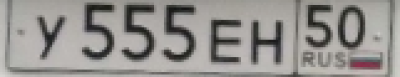

LP Threshold


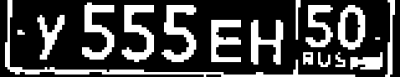

Original Candidates


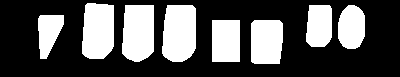

Char Threshold


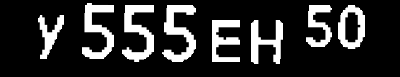

Character 1


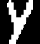

Character 2


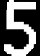

Character 3


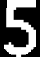

Character 4


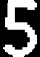

Character 5


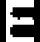

Character 6


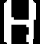

Character 7


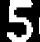

Character 8


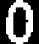

Output image


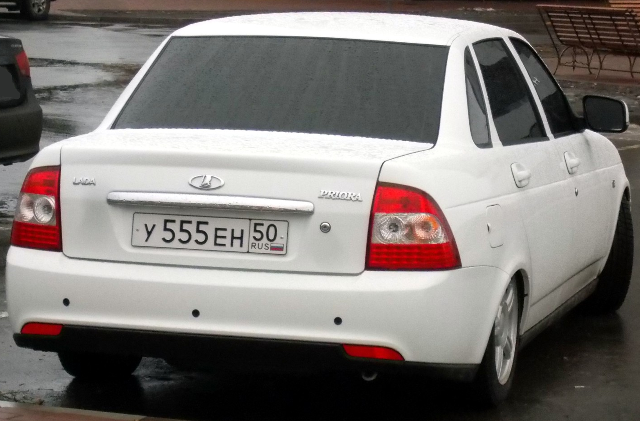



license_plate_test_dataset/y_0002.png
Perspective Transform


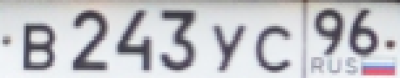

LP Threshold


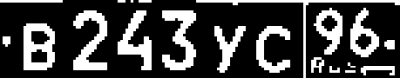

Original Candidates


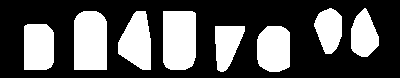

Char Threshold


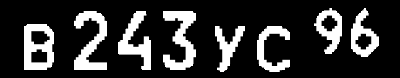

Character 1


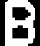

Character 2


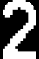

Character 3


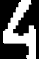

Character 4


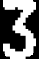

Character 5


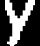

Character 6


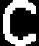

Character 7


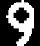

Character 8


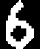

Output image


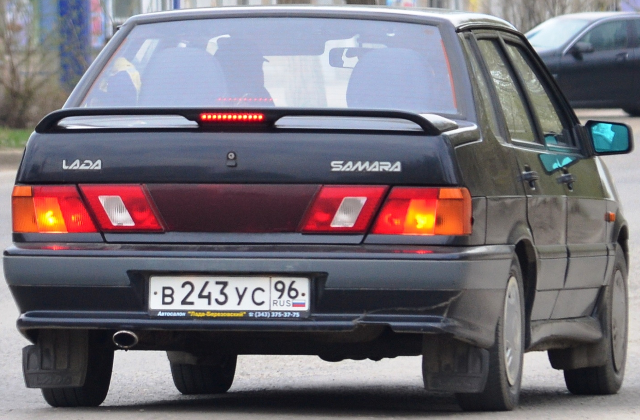



license_plate_test_dataset/y_0003.png
Perspective Transform


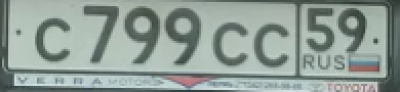

LP Threshold


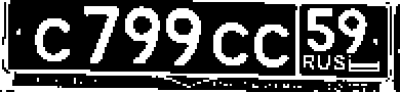

Original Candidates


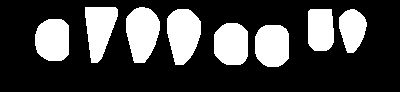

Char Threshold


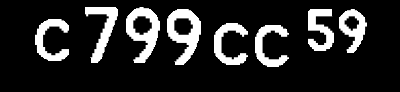

Character 1


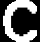

Character 2


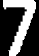

Character 3


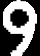

Character 4


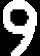

Character 5


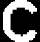

Character 6


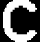

Character 7


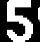

Character 8


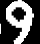

Output image


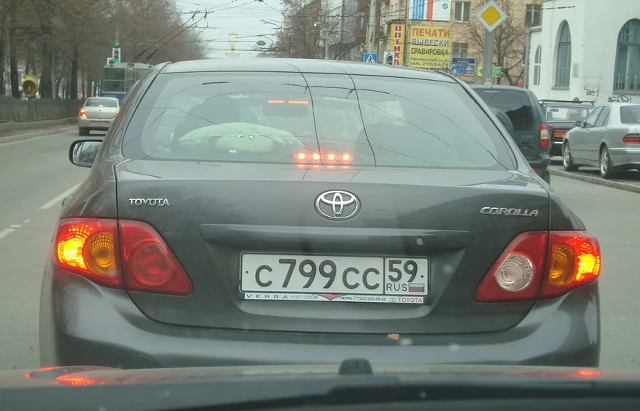



license_plate_test_dataset/y_0004.png
Perspective Transform


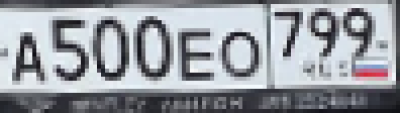

LP Threshold


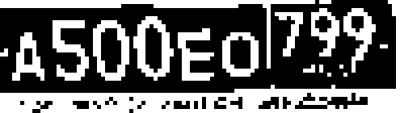

Original Candidates


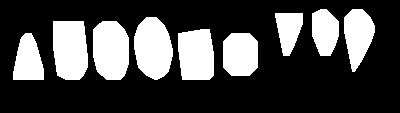

Char Threshold


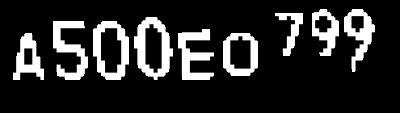

Character 1


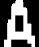

Character 2


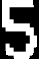

Character 3


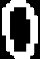

Character 4


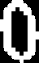

Character 5


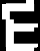

Character 6


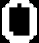

Character 7


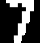

Character 8


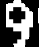

Character 9


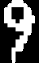

Output image


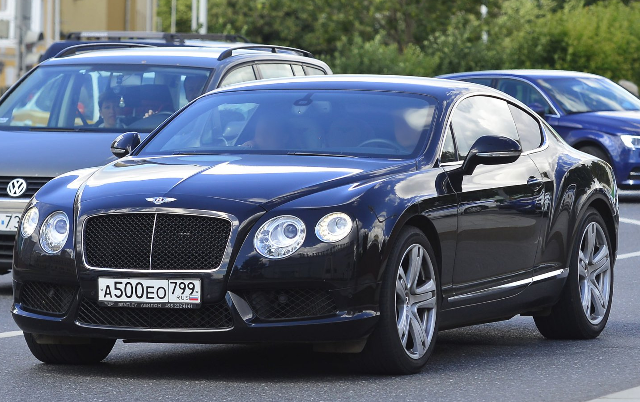



license_plate_test_dataset/y_0005.png
Perspective Transform


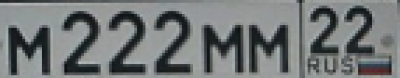

LP Threshold


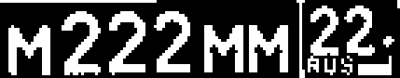

Original Candidates


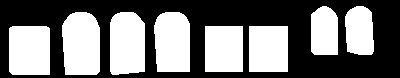

Char Threshold


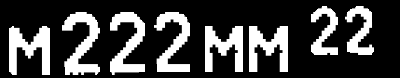

Character 1


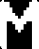

Character 2


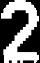

Character 3


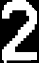

Character 4


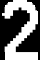

Character 5


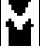

Character 6


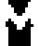

Character 7


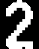

Character 8


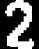

Output image


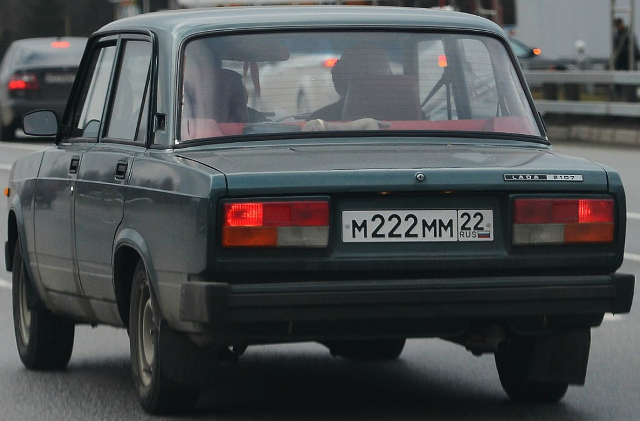

In [6]:
# Сократим список изображений до 5.
# При желании, посмотрите как работает 
# алгоритм на всех изображениях.
images_list = images_list[:5]

# loop over the images
# перебираем изображения
for imagePath in images_list:
    # load the image
    # загружаем изображение
    image = cv2.imread(imagePath)
    print('\n')
    print(imagePath)

    # if the width is greater than 640 pixels, then resize the image
    # если ширина изображения больше 640 пикселей,
    # то изменим размер изображения
    if image.shape[1] > 640:
        image = imutils.resize(image, width=640)

    # initialize the license plate detector and detect the license plates and candidates
    # инициализируем детектор номерных знаков 
    # и локализируем номерные знаки и символы
    lpd = LicensePlateDetector(image)
    plates = lpd.detect()

    # loop over the detected plages
    # перебираем регионы номерных знаков
    for (lpBox, chars) in plates:
        # loop over each character
        # перебираем каждый символ
        for (i, char) in enumerate(chars):
            if char.shape[1] == 0:
                continue
            # show the character
            # покажем символ
            print("Character {}".format(i + 1))
            cv2_imshow(char)

    # display the output image
    # отобразим выходное изоброжание
    print('Output image')
    cv2_imshow(image)